In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
import os
import cv2
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from functools import partial
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import keras
from keras.models import load_model



C:\Users\TSE LATAM\AppData\Local\Temp\ipykernel_4768\4293658283.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Cargar el archivo NPY
intervals = np.load('C:/Users/TSE LATAM/Documents/Navarra/TFM/datasets/medidas_2d/1601/intervals_1601.npy')
intervals_ref = np.load('C:/Users/TSE LATAM/Documents/Navarra/TFM/datasets/medidas_2d/1601/intervals_ref_1601.npy')
labels_1601 = np.load('C:/Users/TSE LATAM/Documents/Navarra/TFM/datasets/medidas_2d/1601/labels_1601.npy')
labels_1601_ref = np.load('C:/Users/TSE LATAM/Documents/Navarra/TFM/datasets/medidas_2d/1601/labels_ref_1601.npy')
test_intervals_1601 = np.load('C:/Users/TSE LATAM/Documents/Navarra/TFM/datasets/medidas_2d/1601/test_intervals_1601.npy')
test_labels_1601 = np.load('C:/Users/TSE LATAM/Documents/Navarra/TFM/datasets/medidas_2d/1601/test_labels_1601.npy')
x_out_1601 = np.load('C:/Users/TSE LATAM/Documents/Navarra/TFM/datasets/medidas_2d/1601/X_out_1601.npy')
x_out_1601_ref = np.load('C:/Users/TSE LATAM/Documents/Navarra/TFM/datasets/medidas_2d/1601/X_out_ref_1601.npy')
x_out_1601_test = np.load('C:/Users/TSE LATAM/Documents/Navarra/TFM/datasets/medidas_2d/1601/X_out_test_1601.npy')

In [3]:
print('intervals:', intervals.shape)
print('intervals_ref:', intervals_ref.shape)
print('labels_1601:', labels_1601.shape)
print('labels_1601_ref:', labels_1601_ref.shape)
print('test_intervals_1601:', test_intervals_1601.shape)
print('test_labels_1601:', test_labels_1601.shape)
print('x_out_1601:', x_out_1601.shape)
print('x_out_1601_ref:', x_out_1601_ref.shape)
print('x_out_1601_test:', x_out_1601_test.shape)


intervals: (4800,)
intervals_ref: (80,)
labels_1601: (4800,)
labels_1601_ref: (80,)
test_intervals_1601: (2400,)
test_labels_1601: (2400,)
x_out_1601: (4800, 1601, 128, 1)
x_out_1601_ref: (80, 1601, 128, 1)
x_out_1601_test: (2400, 1601, 128, 1)


In [4]:
print('intervals:', intervals)

intervals: ['050_080' '050_080' '050_080' ... '110_140' '110_140' '110_140']


In [5]:

# Crear un DataFrame
df = pd.DataFrame({
    'intervals': intervals,   # Asumimos que 'intervals' está previamente cargado
    'labels_1601': labels_1601  # Asumimos que 'labels_1601' está previamente cargado
})

# Combinar 'intervals' y 'labels_1601' en una columna y factorizar para asignar un identificador único
df['category'] = pd.factorize(list(zip(df['intervals'], df['labels_1601'])))[0]

# Usar groupby para agrupar por categoría y recoger los índices en listas
positions_by_category = df.groupby('category').apply(lambda x: x.index.tolist()).tolist()

# Ordenar cada lista de posiciones de forma descendente
positions_by_category_sorted = [sorted(positions, reverse=True) for positions in positions_by_category]

# Convertir la lista de listas en un array de numpy con dtype=object para manejar listas de diferentes longitudes
x_train_a_position = np.array(positions_by_category, dtype=object)
x_train_b_position = np.array(positions_by_category_sorted, dtype=object)

# Opcionalmente, aplana las listas si es necesario para alguna otra operación
indices_x_train_a_position = [item for sublist in x_train_a_position for item in sublist]
indices_x_train_b_position = [item for sublist in x_train_b_position for item in sublist]


C:\Users\TSE LATAM\AppData\Local\Temp\ipykernel_4768\3632705751.py:11: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  df['category'] = pd.factorize(list(zip(df['intervals'], df['labels_1601'])))[0]
C:\Users\TSE LATAM\AppData\Local\Temp\ipykernel_4768\3632705751.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  positions_by_category = df.groupby('category').apply(lambda x: x.index.tolist()).tolist()


In [6]:
df['category'] = pd.factorize(list(zip(df['intervals'], df['labels_1601'])))[0]
df

C:\Users\TSE LATAM\AppData\Local\Temp\ipykernel_4768\415407057.py:1: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  df['category'] = pd.factorize(list(zip(df['intervals'], df['labels_1601'])))[0]


,intervals,labels_1601,category
0,050_080,tag_00001_4x4,0
1,050_080,tag_00001_4x4,0
2,050_080,tag_00001_4x4,0
3,050_080,tag_00001_4x4,0
4,050_080,tag_00001_4x4,0
...,...,...,...
4795,110_140,tag_11111_1x1,47
4796,110_140,tag_11111_1x1,47
4797,110_140,tag_11111_1x1,47
4798,110_140,tag_11111_1x1,47


In [7]:
# Crear un DataFrame
df_2 = pd.DataFrame({
    'test_intervals_1601': test_intervals_1601,
    'test_labels_1601': test_labels_1601
})

# Combinar 'test_intervals_1601' y 'test_labels_1601' en una columna y factorizar para asignar un identificador único
df_2['category'] = pd.factorize(list(zip(df_2['test_intervals_1601'], df_2['test_labels_1601'])))[0]

# Usar groupby para agrupar por categoría y recoger los índices en listas
positions_by_category_y = df_2.groupby('category').apply(lambda x: x.index.tolist()).tolist()

# Ordenar cada lista de posiciones de forma descendente
positions_by_category_sorted_y = [sorted(positions, reverse=True) for positions in positions_by_category_y]

# Convertir la lista de listas en un array de numpy con dtype=object para manejar listas de diferentes longitudes
y_test_a_position = np.array(positions_by_category_y, dtype=object)
y_test_b_position = np.array(positions_by_category_sorted_y, dtype=object)

# Opcionalmente, aplana las listas si es necesario para alguna otra operación
indices_y_test_a_position = [item for sublist in y_test_a_position for item in sublist]
indices_y_test_b_position = [item for sublist in y_test_b_position for item in sublist]

# Descomentar si necesitas imprimir las posiciones
# print("Array de posiciones por categoría:")
# for idx, positions in enumerate(y_test_a_position):
#     print(f"Categoría {idx}: {positions}")

# print("Array de posiciones ordenadas por categoría:")
# for idx, positions in enumerate(y_test_b_position):
#     print(f"Categoría {idx}: {positions}")


C:\Users\TSE LATAM\AppData\Local\Temp\ipykernel_4768\1458930804.py:11: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  df_2['category'] = pd.factorize(list(zip(df_2['test_intervals_1601'], df_2['test_labels_1601'])))[0]
C:\Users\TSE LATAM\AppData\Local\Temp\ipykernel_4768\1458930804.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  positions_by_category_y = df_2.groupby('category').apply(lambda x: x.index.tolist()).tolist()


In [30]:
def build_autoencoder():
    # Define la entrada con el nuevo tamaño de imagen
    input_img = Input(shape=(1600, 128, 1))

    # Encoder
    x = Conv2D(32, (3, 3), padding='same')(input_img)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder

# Construir el modelo
autoencoder = build_autoencoder()
autoencoder.summary()



c:\Users\TSE LATAM\.conda\envs\reto\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1600, 128, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 1600, 128, 32)  │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 1600, 128, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1600, 128, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 800, 64, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 800, 64, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 800, 64, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 800, 64, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 400, 32, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 400, 32, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 400, 32, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 400, 32, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 200, 16, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 400, 32, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 400, 32, 128)   │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 400, 32, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 400, 32, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 800, 64, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 800, 64, 64)    │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 800, 64, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 800, 64, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 1600, 128, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 334,593 (1.28 MB)

 Trainable params: 333,697 (1.27 MB)

 Non-trainable params: 896 (3.50 KB)

In [8]:
# Reordenar los datasets según los índices proporcionados
x_train = x_out_1601[indices_x_train_a_position]
x_train_b = x_out_1601[indices_x_train_b_position]
x_test = x_out_1601_test[indices_y_test_a_position]
x_test_b = x_out_1601_test[indices_y_test_b_position]

# Recortar un píxel de la parte superior de cada imagen en todos los datasets
x_train = x_train[:, 1:1601, :, :]
x_train_b = x_train_b[:, 1:1601, :, :]
x_test = x_test[:, 1:1601, :, :]
x_test_b = x_test_b[:, 1:1601, :, :]

In [9]:
print("Dimensiones de x_train:", x_train.shape)
print("Dimensiones de x_train_b:", x_train_b.shape)
print("Dimensiones de x_test:", x_test.shape)
print("Dimensiones de x_test_b:", x_test_b.shape)

# Normalizar los datos de entrenamiento y prueba
x_train = x_train.astype('float32') / 255.0
x_train_b = x_train_b.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_test_b = x_test_b.astype('float32') / 255.0

Dimensiones de x_train: (4800, 1600, 128, 1)
Dimensiones de x_train_b: (4800, 1600, 128, 1)
Dimensiones de x_test: (2400, 1600, 128, 1)
Dimensiones de x_test_b: (2400, 1600, 128, 1)


Epoch 1/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - loss: 0.0749 
Epoch 1: val_loss improved from inf to 0.04614, saving model to autoencoder_best_2.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 2310s 15s/step - loss: 0.0747 - val_loss: 0.0461 - learning_rate: 0.0010
Epoch 2/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - loss: 0.0285 
Epoch 2: val_loss improved from 0.04614 to 0.03533, saving model to autoencoder_best_2.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 2251s 15s/step - loss: 0.0285 - val_loss: 0.0353 - learning_rate: 0.0010
Epoch 3/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - loss: 0.0276 
Epoch 3: val_loss improved from 0.03533 to 0.02545, saving model to autoencoder_best_2.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 2372s 16s/step - loss: 0.0276 - val_loss: 0.0255 - learning_rate: 0.0010
Epoch 4/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - loss: 0.0266 
Epoch 4: val_loss improved from 0.02545 to 0.02213, saving model to autoencoder_best_2.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 2207s 15s/step - loss: 0.

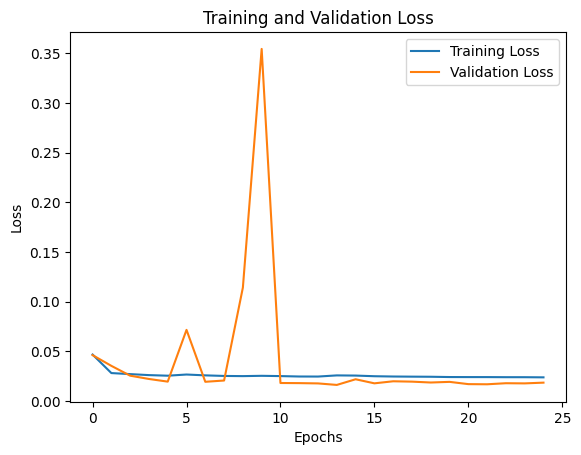

In [33]:

# Configuración del entrenamiento del autoencoder
callbacks = [
    ModelCheckpoint('autoencoder_best_2.keras', verbose=1, save_best_only=True, save_weights_only=False),
    ReduceLROnPlateau(factor=0.5, patience=5, min_lr=0.00001, verbose=1)
]

history = autoencoder.fit(
    x=x_train,
    y=x_train_b,
    epochs=25,
    batch_size=32,
    shuffle=True,
    validation_data=(x_test, x_test_b),
    callbacks=callbacks
)

# Evaluación del modelo en el conjunto de prueba
test_loss = autoencoder.evaluate(x_test, x_test_b)
print("Test loss (MSE):", test_loss)

# Plotting training and validation losses
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



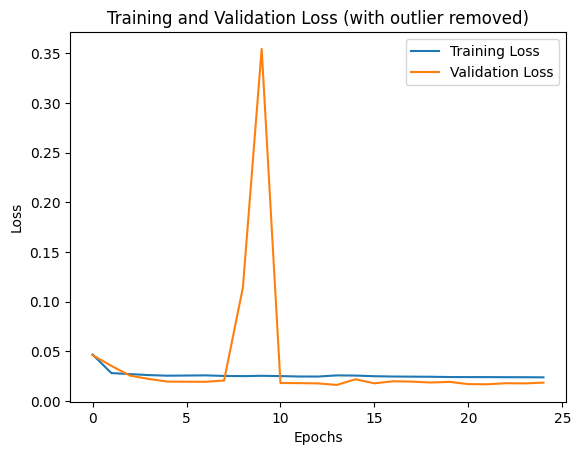

In [34]:

# Assuming `history.history['loss']` and `history.history['val_loss']` are lists containing loss values.
# Epochs are 0-indexed in Python, so epoch 6 is at index 5.

# Remove the outlier by setting it to None
train_losses = history.history['loss'][:]
val_losses = history.history['val_loss'][:]

# Alternatively, you could average the values before and after the outlier if it's appropriate:
mean_train = (train_losses[4] + train_losses[6]) / 2
mean_val = (val_losses[4] + val_losses[6]) / 2
train_losses[5] = mean_train
val_losses[5] = mean_val

# Plot the modified data
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss (with outlier removed)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


75/75 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step


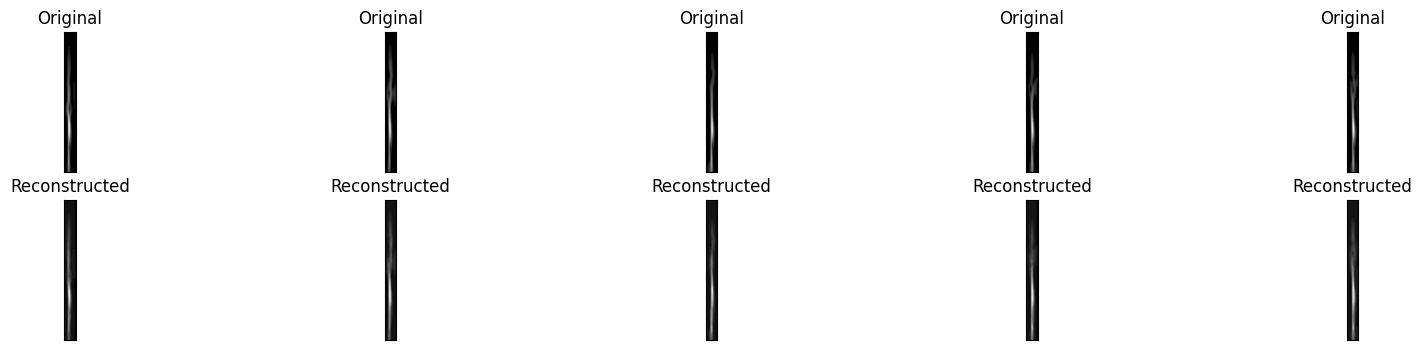

In [35]:
decoded_imgs = autoencoder.predict(x_test)
n = 5
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(1600, 128), cmap='gray')
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(1600, 128), cmap='gray')
    plt.title("Reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


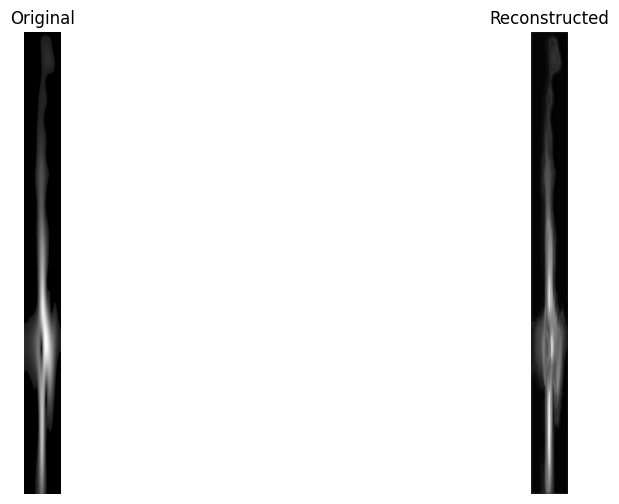

In [18]:
# Path to the pretrained model (HDF5 file)
model_path = "C:/Users/TSE LATAM/Documents/Navarra/TFM/notebooks/autoencoder_best_2.keras"

# Path to the input image
image_path = "C:/Users/TSE LATAM/Documents/Navarra/TFM/datasets/Medidas_en_2D/train/image_100.png"

# Function to load and prepare the image
def prepare_image(img_path):
    # Check if the file exists
    if not os.path.exists(img_path):
        print(f"The file {img_path} does not exist.")
        return None

    # Load image in grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Failed to load image from {img_path}.")
        return None

    # Resize image to match the model's expected input dimensions
    img = cv2.resize(img, (128, 1600))  # Ensure the dimensions are correct
    img = np.array(img).astype('float32') / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=-1)  # Add a channel dimension
    img = np.expand_dims(img, axis=0)  # Add a batch dimension for prediction
    return img

# Prepare the image
input_image = prepare_image(image_path)

# Load the trained autoencoder model
autoencoder = load_model(model_path)

if input_image is not None:
    # Perform prediction
    decoded_image = autoencoder.predict(input_image)

    # Display the original and reconstructed images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(input_image[0].reshape(1600, 128), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(decoded_image[0].reshape(1600, 128), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

    plt.show()
else:
    print("The image could not be prepared, and no prediction was performed.")


x_out_1601 shape: (4800, 1601, 128, 1)
labels_1601 shape: (4800,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


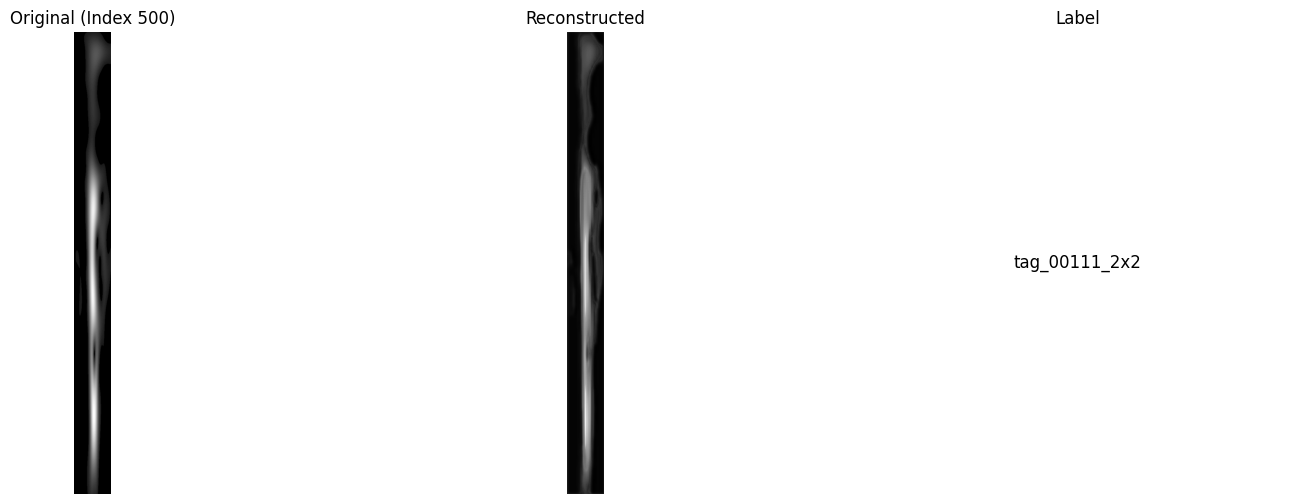

In [10]:
# Path to the pretrained model 
model_path = "C:/Users/TSE LATAM/Documents/Navarra/TFM/notebooks/autoencoder_best_2.keras"

# Function to prepare the image for model input
def prepare_image(image):
    image = image.astype('float32') / 255.0  # Normalize pixel values
    image = np.expand_dims(image, axis=0)  # Add a batch dimension for prediction
    return image

# Load the trained autoencoder model
autoencoder = load_model(model_path)

# Check the dimensions of the arrays
print(f"x_out_1601 shape: {x_out_1601.shape}")
print(f"labels_1601 shape: {labels_1601.shape}")

# Ensure x_out_1601 has the correct shape
x_out_1601 = x_out_1601[:, :1600, :, :]

# Select the index of the image to be reconstructed
index = 500  # Change this index to the desired image index

# Extract the specific image and label based on the index
original_image = x_out_1601[index]
label = labels_1601[index]

# Prepare the image for prediction
input_image = prepare_image(original_image)

# Perform prediction
decoded_image = autoencoder.predict(input_image)

# Display the original image, reconstructed image, and label
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(original_image.squeeze(), cmap='gray')
plt.title(f"Original (Index {index})")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(decoded_image[0].squeeze(), cmap='gray')
plt.title("Reconstructed")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.text(0.5, 0.5, str(label), horizontalalignment='center', verticalalignment='center', fontsize=12)
plt.title("Label")
plt.axis('off')

plt.show()


In [10]:
# Función para imprimir valores únicos y sus conteos
def print_unique_counts(data):
    values, counts = np.unique(data, return_counts=True)
    for value, count in zip(values, counts):
        print(f'Value: {value}, Count: {count}')

# Imprimir valores únicos y sus conteos para 'intervals_ref' y 'intervals'
print_unique_counts(intervals_ref)
print_unique_counts(intervals)

# Crear DataFrame df_3
df_3 = pd.DataFrame({
    'intervals': intervals_ref,
    'labels_1601': labels_1601_ref
})

# Reemplazo de valores en la columna 'intervals'
replacement_dict = {
    '000_050': '050_080',
    '000_080': '050_080',
    '000_110': '080_110',
    '000_140': '110_140'
}
df_3['intervals'] = df_3['intervals'].replace(replacement_dict)

# Preparar df_2 para el merge, asumiendo que 'df_2' está previamente cargado
df_index = df_2.drop_duplicates(subset='category')[['category', 'test_intervals_1601', 'test_labels_1601']]
df_index.rename(columns={'test_intervals_1601': 'intervals', 'test_labels_1601': 'labels_1601'}, inplace=True)

# Hacer un merge de df_3 con df_index
df_3 = pd.merge(df_3, df_index, on=['intervals', 'labels_1601'], how='left')
df_3.dropna(subset=['category'], inplace=True)

# Extraer array de categorías
category_array = df_3['category'].values
print(category_array)


Value: 000_020, Count: 16
Value: 000_050, Count: 16
Value: 000_080, Count: 16
Value: 000_110, Count: 16
Value: 000_140, Count: 16
Value: 050_080, Count: 1600
Value: 080_110, Count: 1600
Value: 110_140, Count: 1600
[ 0.  0.  1.  2.  3.  3.  4.  5.  6.  6.  7.  8.  9.  9. 10. 11. 12. 12.
 13. 14. 15. 15. 16. 17. 18. 18. 19. 20. 21. 21. 22. 23. 24. 24. 25. 26.
 27. 27. 28. 29. 30. 30. 31. 32. 33. 33. 34. 35. 36. 36. 37. 38. 39. 39.
 40. 41. 42. 42. 43. 44. 45. 45. 46. 47.]


In [11]:
unique_categories = np.unique(category_array)
index_array = []

for category in unique_categories:
    position = df_3[df_3['category'] == category].index
    if position.size > 0:
        index_array.append(position[0])

index_array = np.array(index_array)
index_array.shape

(48,)

In [12]:
unique_categories = np.unique(category_array)
index_array_test = []

for category in unique_categories:
    position = np.where(df_2['category'] == category)[0]
    if position.size > 0:
        index_array_test.append(df_2.index[position[0]])

index_array_test = np.array(index_array_test)
index_array_test.shape

(48,)

In [13]:
# Reordenar los datasets según los índices proporcionados
x_ref = x_out_1601_ref[index_array]
x_test_not_atc = x_out_1601_test[index_array_test]
x_test_atc = x_out_1601_test[index_array_test]

# Recortar un píxel de la parte superior de cada imagen en todos los datasets
x_ref = x_ref[:, 1:1601, :, :]
x_test_not_atc = x_test_not_atc[:, 1:1601, :, :]
x_test_atc = x_test_atc[:, 1:1601, :, :]

In [14]:
print("Dimensiones de x_ref:", x_ref.shape)
print("Dimensiones de x_test_not_autoencoder:", x_test_not_atc.shape)
print("Dimensiones de x_test_autoencoder:", x_test_atc.shape)


# Normalizar los datos de entrenamiento y prueba
x_ref = x_ref.astype('float32') / 255.0
x_test_not_atc = x_test_not_atc.astype('float32') / 255.0
x_test_atc = x_test_atc.astype('float32') / 255.0


Dimensiones de x_ref: (48, 1600, 128, 1)
Dimensiones de x_test_not_autoencoder: (48, 1600, 128, 1)
Dimensiones de x_test_autoencoder: (48, 1600, 128, 1)


In [15]:

def flatten_images(img1, img2):
    """Flatten the input images."""
    return img1.flatten(), img2.flatten()

def calculate_mse(img1, img2):
    """Calculate Mean Squared Error between two images."""
    return mean_squared_error(img1, img2)

def calculate_pearson(img1, img2):
    """Calculate Pearson correlation coefficient between two images."""
    return pearsonr(img1, img2)[0]

def calculate_psnr(mse):
    """Calculate PSNR based on MSE."""
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

# Input images
x_ref_flat, x_test_not_atc_flat = flatten_images(x_ref, x_test_not_atc)

# Calculating metrics
mse = calculate_mse(x_ref_flat, x_test_not_atc_flat)
pearson_corr = calculate_pearson(x_ref_flat, x_test_not_atc_flat)
psnr = calculate_psnr(mse)

# Output results
print(f"MSE: {mse}, PSNR: {psnr}, Pearson Correlation: {pearson_corr}")


MSE: 0.01608917862176895, PSNR: 66.06546497248107, Pearson Correlation: 0.8029032242263804


In [16]:
# múltiples pares de imágenes
num_images = x_ref.shape[0]  # Número de pares de imágenes
results = []  # Lista para almacenar los resultados

# Iterar a través de cada par de imágenes
for i in range(num_images):
    x_ref_flat, x_test_not_atc_flat = flatten_images(x_ref[i], x_test_not_atc[i])
    mse = calculate_mse(x_ref_flat, x_test_not_atc_flat)
    pearson_corr = calculate_pearson(x_ref_flat, x_test_not_atc_flat)
    psnr = calculate_psnr(mse)
    results.append([mse, psnr, pearson_corr])

# Crear un DataFrame a partir de los resultados
df_results = pd.DataFrame(results, columns=['MSE', 'PSNR', 'Pearson Correlation'])

# Mostrar el DataFrame
print(df_results)

         MSE       PSNR  Pearson Correlation
0   0.004180  71.919431             0.936958
1   0.002924  73.470582             0.956863
2   0.003365  72.860930             0.949726
3   0.010969  67.729114             0.839964
4   0.011043  67.699975             0.854293
5   0.010051  68.108732             0.880529
6   0.002536  74.089073             0.970406
7   0.001815  75.541968             0.973811
8   0.001761  75.674320             0.972505
9   0.016885  65.855718             0.773684
10  0.010607  67.874887             0.883875
11  0.019700  65.186040             0.817574
12  0.009518  68.345119             0.890783
13  0.012560  67.140793             0.873755
14  0.006119  70.263839             0.925859
15  0.010807  67.793700             0.899361
16  0.000869  78.741966             0.988774
17  0.001935  75.264505             0.975235
18  0.011204  67.636938             0.822875
19  0.071888  59.564248             0.162361
20  0.103874  57.965715            -0.411295
21  0.0140

In [17]:
def flatten_images(img1, img2):
    """Flatten the input images."""
    return img1.flatten(), img2.flatten()

def calculate_mse(img1, img2):
    """Calculate Mean Squared Error between two images."""
    return mean_squared_error(img1, img2)

def calculate_pearson(img1, img2):
    """Calculate Pearson correlation coefficient between two images."""
    return pearsonr(img1, img2)[0]

def calculate_psnr(mse):
    """Calculate PSNR based on MSE."""
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

# Cargar el modelo autoencoder guardado
model_path = "C:/Users/TSE LATAM/Documents/Navarra/TFM/notebooks/autoencoder_best_2.keras"
autoencoder = load_model(model_path)

# Usar el modelo para reconstruir las imágenes
x_test_atc_reconstructed = autoencoder.predict(x_test_atc)

# Aplanar las imágenes para las comparaciones
x_ref_flat, x_test_atc_reconstructed_flat = flatten_images(x_ref, x_test_atc_reconstructed)

# Calculating metrics
mse = calculate_mse(x_ref_flat, x_test_atc_reconstructed_flat)
pearson_corr = calculate_pearson(x_ref_flat, x_test_atc_reconstructed_flat)
psnr = calculate_psnr(mse)

# Output results
print(f"MSE: {mse}, PSNR: {psnr}, Pearson Correlation: {pearson_corr}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
MSE: 0.014279806055128574, PSNR: 66.58358061797057, Pearson Correlation: 0.8103572706315512


In [18]:
# Número de pares de imágenes
num_images = x_ref.shape[0]
results = []

# Iterar a través de cada par de imágenes
for i in range(num_images):
    x_ref_flat, x_test_atc_reconstructed_flat = flatten_images(x_ref[i], x_test_atc_reconstructed[i])
    mse = calculate_mse(x_ref_flat, x_test_atc_reconstructed_flat)
    pearson_corr = calculate_pearson(x_ref_flat, x_test_atc_reconstructed_flat)
    psnr = calculate_psnr(mse)
    results.append([mse, psnr, pearson_corr])

# Crear un DataFrame a partir de los resultados
df_results_2 = pd.DataFrame(results, columns=['MSE', 'PSNR', 'Pearson Correlation'])

# Mostrar el DataFrame
print(df_results_2)

         MSE       PSNR  Pearson Correlation
0   0.005985  70.360069             0.919613
1   0.004421  71.675244             0.943788
2   0.005293  70.893844             0.927590
3   0.010865  67.770528             0.841282
4   0.011361  67.576585             0.852130
5   0.011377  67.570640             0.874816
6   0.004094  72.009718             0.961602
7   0.004768  71.347090             0.941004
8   0.004502  71.596910             0.936624
9   0.015121  66.335134             0.783232
10  0.007702  69.264906             0.919103
11  0.018215  65.526484             0.813857
12  0.010749  67.816966             0.882159
13  0.013528  66.818380             0.855098
14  0.008448  68.863465             0.908435
15  0.010501  67.918549             0.876312
16  0.003022  73.328097             0.969238
17  0.004321  71.775089             0.958296
18  0.010565  67.892011             0.836578
19  0.051246  61.034164             0.213675
20  0.077153  59.257252            -0.434104
21  0.0083

In [20]:
def filter_cwt(X, thr):
    X_copy = X.copy()
    X_copy[X_copy < thr] = 0
    return X_copy

In [21]:
thr = 0.1
x_test_atc = filter_cwt(x_test_atc, thr)

In [74]:
# Cargar el modelo autoencoder guardado , con esto validaremos si hay diferencia estadistica entre el filtrado o no
model_path = "C:/Users/TSE LATAM/Documents/Navarra/TFM/notebooks/autoencoder_filtred_train.keras"
autoencoder = load_model(model_path)

# Usar el modelo para reconstruir las imágenes
x_test_atc_filtred_reconstructed = autoencoder.predict(x_test_atc)

# Aplanar las imágenes para las comparaciones
x_ref_flat, x_test_atc_filtred_reconstructed_flat = flatten_images(x_ref, x_test_atc_filtred_reconstructed)

# Calculating metrics
mse = calculate_mse(x_ref_flat, x_test_atc_filtred_reconstructed_flat)
pearson_corr = calculate_pearson(x_ref_flat, x_test_atc_filtred_reconstructed_flat)
psnr = calculate_psnr(mse)

# Output results
print(f"MSE: {mse}, PSNR: {psnr}, Pearson Correlation: {pearson_corr}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
MSE: 0.01176017802208662, PSNR: 67.42666457391543, Pearson Correlation: 0.8571290940673872


In [75]:
print(x_ref_flat.shape),
print(x_test_atc_filtred_reconstructed_flat.shape)

(9830400,)
(9830400,)


In [77]:
# Número de pares de imágenes
num_images = x_ref.shape[0]
results = []

# Iterar a través de cada par de imágenes
for i in range(num_images):
    x_ref_flat, x_test_atc_filtred_reconstructed_flat = flatten_images(x_ref[i], x_test_atc_filtred_reconstructed[i])
    mse = calculate_mse(x_ref_flat, x_test_atc_filtred_reconstructed_flat)
    pearson_corr = calculate_pearson(x_ref_flat, x_test_atc_filtred_reconstructed_flat)
    psnr = calculate_psnr(mse)
    results.append([mse, psnr, pearson_corr])

# Crear un DataFrame a partir de los resultados
df_results_3 = pd.DataFrame(results, columns=['MSE', 'PSNR', 'Pearson Correlation'])

# Mostrar el DataFrame
print(df_results_3)

         MSE       PSNR  Pearson Correlation
0   0.006868  69.762805             0.933735
1   0.005917  70.409601             0.955033
2   0.006829  69.786987             0.933534
3   0.009991  68.134823             0.871632
4   0.011329  67.588812             0.857394
5   0.011263  67.614106             0.900923
6   0.005903  70.420421             0.954949
7   0.005101  71.054396             0.961870
8   0.004576  71.526345             0.964231
9   0.013486  66.832011             0.813034
10  0.006560  69.961673             0.948788
11  0.012581  67.133556             0.885843
12  0.010324  67.992216             0.892222
13  0.010078  68.096967             0.911166
14  0.008884  68.644636             0.929524
15  0.009636  68.291819             0.902812
16  0.004563  71.538484             0.967066
17  0.006026  70.330237             0.956079
18  0.009627  68.295951             0.867096
19  0.030205  63.330017             0.416028
20  0.048641  61.260816            -0.327438
21  0.0076

In [47]:
import numpy as np
from scipy.stats import wilcoxon

stat, p = wilcoxon(df_results['MSE'], df_results_2['MSE'])
print("MSE-Estadístico de Wilcoxon:", stat)
print("MSE-P-valor:", p)

stat, p = wilcoxon(df_results['PSNR'], df_results_2['PSNR'])
print("PSNR-Estadístico de Wilcoxon:", stat)
print("PSNR-P-valor:", p)

stat, p = wilcoxon(df_results['Pearson Correlation'], df_results_2['Pearson Correlation'])
print("Pearson-Estadístico de Wilcoxon:", stat)
print("Pearson-P-valor:", p)

MSE-Estadístico de Wilcoxon: 559.0
MSE-P-valor: 0.7720742559715248
PSNR-Estadístico de Wilcoxon: 382.0
PSNR-P-valor: 0.034205064013136166
Pearson-Estadístico de Wilcoxon: 385.0
Pearson-P-valor: 0.03699290802472888


**Parte III .- A nivel de varianzas ambos errores no difieren significativamente, por lo que ahora toca validar a nivel de clasificacion con el algoritmo tercero**

In [48]:
# Normalizar los datos de entrenamiento y prueba
x_out_1601 = x_out_1601.astype('float32') / 255.0
x_out_1601_test = x_out_1601_test.astype('float32') / 255.0

print('intervals:', intervals.shape)
print('labels_1601:', labels_1601.shape)
print('x_out_1601:', x_out_1601.shape)

print('test_intervals_1601:', test_intervals_1601.shape)
print('test_labels_1601:', test_labels_1601.shape)
print('x_out_1601_test:', x_out_1601_test.shape)


intervals: (4800,)
labels_1601: (4800,)
x_out_1601: (4800, 1601, 128, 1)
test_intervals_1601: (2400,)
test_labels_1601: (2400,)
x_out_1601_test: (2400, 1601, 128, 1)


In [50]:
thr = 0.1
x = filter_cwt(x_out_1601, thr)
y = filter_cwt(x_out_1601_test, thr)

c:\Users\TSE LATAM\.conda\envs\reto\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step - accuracy: 0.0851 - loss: 2.7590 - val_accuracy: 0.2037 - val_loss: 2.6683
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 95ms/step - accuracy: 0.2036 - loss: 2.5581 - val_accuracy: 0.6267 - val_loss: 2.0520
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 15s 97ms/step - accuracy: 0.4011 - loss: 1.9258 - val_accuracy: 0.7542 - val_loss: 1.1674
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - accuracy: 0.5957 - loss: 1.2285 - val_accuracy: 0.7504 - val_loss: 0.9518
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 95ms/step - accuracy: 0.7150 - loss: 0.8875 - val_accuracy: 0.7613 - val_loss: 0.8353
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - accuracy: 0.7819 - loss: 0.7043 - val_accuracy: 0.8292 - val_loss: 0.7294
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 15s 101ms/step - accuracy: 0.8021 - loss: 0.5900 - val_accuracy: 0.8296 - val_loss: 0.7295
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 15s 101ms/step - accuracy: 0.8434 - loss

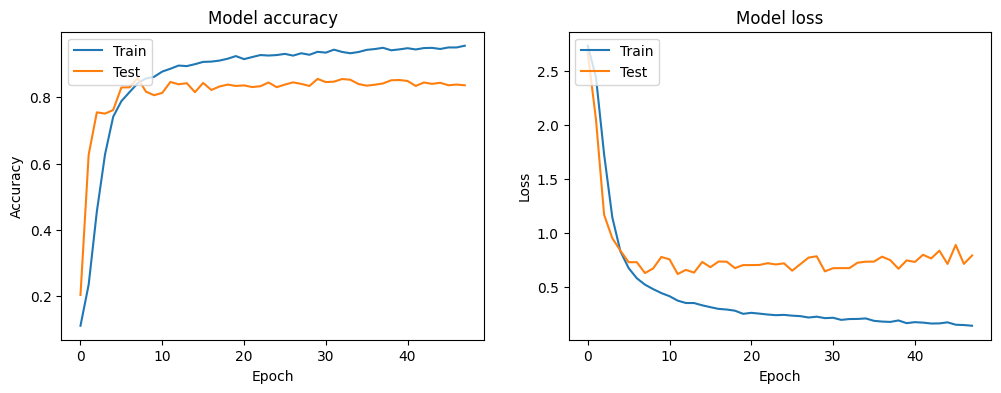

75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step


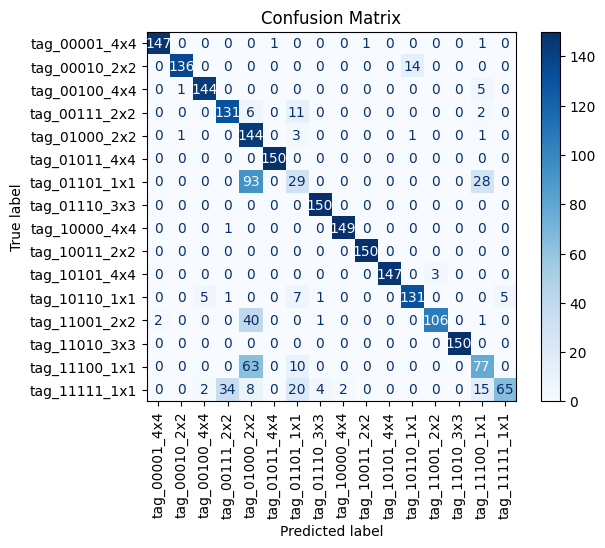

Exactitud del modelo: 83.58%
Tasa de errores: 16.42%


In [51]:
# Convert string labels to numerical labels
label_encoder = LabelEncoder()
labels_1601_categorical = label_encoder.fit_transform(labels_1601)
labels_1601_categorical_test = label_encoder.transform(test_labels_1601)

DefaultConv2D = partial(
    tf.keras.layers.Conv2D,
    kernel_size=5,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)

model = tf.keras.Sequential([
    DefaultConv2D(filters=2, input_shape=(1601, 128, 1)),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    DefaultConv2D(filters=4),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=8),
    tf.keras.layers.MaxPool2D(pool_size=(3,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=16, activation='softmax')
])

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0.01, patience=10)

model.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3),
                metrics=['accuracy'])

# Train the model
history = model.fit(x, labels_1601_categorical, epochs=100, validation_data=(y, labels_1601_categorical_test), callbacks=[callback])


# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

# Generate predictions and plot confusion matrix
y_pred = model.predict(x_out_1601_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(labels_1601_categorical_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.title('Confusion Matrix')
plt.show()

# Calcula y muestra la exactitud y la tasa de errores
accuracy = np.trace(cm) / np.sum(cm)
print(f"Exactitud del modelo: {accuracy * 100:.2f}%")
error_rate = 1 - accuracy
print(f"Tasa de errores: {error_rate * 100:.2f}%")

In [52]:

x_train_autec = x[:, 1:1601, :, :]
x_test_autec = y[:, 1:1601, :, :]

# Cargar el modelo
model_path = "C:/Users/TSE LATAM/Documents/Navarra/TFM/notebooks/autoencoder_best_2.keras"
model = load_model(model_path)

# Predecir usando el modelo cargado
predictions_train = model.predict(x_train_autec)
predictions_test = model.predict(x_test_autec)

# Guardar las predicciones a archivos .npy para fácil carga posterior
np.save('predictions_train.npy', predictions_train)
np.save('predictions_test.npy', predictions_test)

print("Predicciones guardadas correctamente.")


150/150 ━━━━━━━━━━━━━━━━━━━━ 352s 2s/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step
Predicciones guardadas correctamente.


c:\Users\TSE LATAM\.conda\envs\reto\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 17s 110ms/step - accuracy: 0.0909 - loss: 2.7541 - val_accuracy: 0.1608 - val_loss: 2.6866
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 15s 103ms/step - accuracy: 0.1382 - loss: 2.6757 - val_accuracy: 0.3862 - val_loss: 2.4690
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 16s 104ms/step - accuracy: 0.2518 - loss: 2.4070 - val_accuracy: 0.6100 - val_loss: 1.8113
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 16s 105ms/step - accuracy: 0.4354 - loss: 1.8088 - val_accuracy: 0.7204 - val_loss: 1.1883
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 15s 102ms/step - accuracy: 0.5704 - loss: 1.3025 - val_accuracy: 0.7962 - val_loss: 0.9627
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 15s 101ms/step - accuracy: 0.6627 - loss: 1.0009 - val_accuracy: 0.8121 - val_loss: 0.8303
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 15s 102ms/step - accuracy: 0.7488 - loss: 0.7894 - val_accuracy: 0.8004 - val_loss: 0.7507
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 15s 102ms/step - accuracy: 0.7639 -

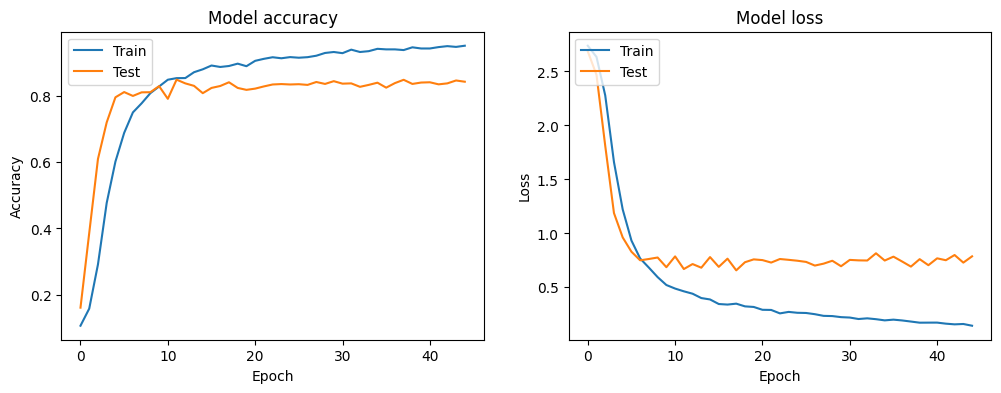

75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step


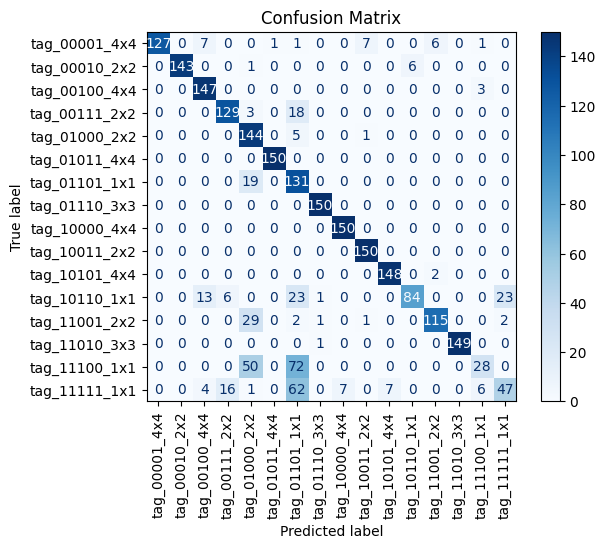

Exactitud del modelo: 83.00%
Tasa de errores: 17.00%


In [53]:
DefaultConv2D = partial(
    tf.keras.layers.Conv2D,
    kernel_size=5,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)

model = tf.keras.Sequential([
    DefaultConv2D(filters=2, input_shape=(1600, 128, 1)),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    DefaultConv2D(filters=4),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=8),
    tf.keras.layers.MaxPool2D(pool_size=(3,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=16, activation='softmax')
])

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0.01, patience=10)

model.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3),
                metrics=['accuracy'])

# Train the model
history = model.fit(predictions_train, labels_1601_categorical, epochs=100, validation_data=(predictions_test, labels_1601_categorical_test), callbacks=[callback])


# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

# Generate predictions and plot confusion matrix
y_pred = model.predict(x_test_autec)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(labels_1601_categorical_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.title('Confusion Matrix')
plt.show()

# Calcula y muestra la exactitud y la tasa de errores
accuracy = np.trace(cm) / np.sum(cm)
print(f"Exactitud del modelo: {accuracy * 100:.2f}%")
error_rate = 1 - accuracy
print(f"Tasa de errores: {error_rate * 100:.2f}%")